In [17]:
import pickle
import torch
import numpy as np
import pandas as pd

from models.bnkf import BNKF
from helper.evaluator import Evaluator
from helper.functions import visualize_dual_3d_scatter, store_truth_data, convert_std_list_to_matrix
from helper.trajectory import Trajectory
from models.stonesoup_radar_sim import StonesoupRadarSim
from copy import deepcopy

In [18]:
with open("../../dataset/dataframe-readins/train/nn_truth_dict.pkl", "rb") as f:
    nn_train_traj_data = pickle.load(f)

In [19]:
with open("../../dataset/dataframe-readins/test/nn_truth_dict.pkl", "rb") as b:
    nn_test_traj_data = pickle.load(b)

In [20]:
display(nn_train_traj_data[1])
print(len(nn_train_traj_data))

,timestamp,tx,ty,tz,vx,vy,vz,delta_time
0,0.000000,-20.110498,2.792424,17.071516,0.827515,-0.114170,0.334543,0.100000
1,0.100000,-20.027747,2.781007,17.104970,0.687851,-0.017778,0.435271,0.100000
2,0.200000,-19.958962,2.779229,17.148497,0.606798,0.254735,0.726220,0.100000
3,0.300000,-19.898282,2.804703,17.221119,0.404264,0.639850,0.534433,0.100000
4,0.400000,-19.857856,2.868688,17.274563,0.153350,1.112576,0.332398,0.100000
...,...,...,...,...,...,...,...,...
106,10.599990,-20.257326,2.629376,17.441737,1.766745,-0.467622,-0.002527,0.099999
107,10.699989,-20.080653,2.582614,17.441485,1.938434,-0.349553,-0.007145,0.100000
108,10.799990,-19.886808,2.547659,17.440770,1.778946,-0.197787,0.023802,0.100000
109,10.899990,-19.708913,2.527880,17.443150,1.931858,-0.032218,0.076908,0.099999


4584


In [21]:
def return_sampled_df(traj_obj_in, a_sample_pct_rmv):
    traj_obj_in.apply_sampling_gaps(a_sample_pct_rmv)
    traj_obj_in.set_converted_measurement_data(measurement_conversion_data, vel=True)
    traj_obj_in.set_measurement_sigmas(radar_simulator.bearing_std, radar_simulator.elev_std,radar_simulator.range_std, radar_simulator.range_rate_std)
    sample_df = traj_obj_in.return_trajectory_df()
    return traj_obj_in.return_nn_prepared_df(sample_df)

In [22]:
sensor_noise = 'low'
incl_rr = True

X_columns = ["measured_x", "measured_y", "measured_z", "measured_vx", "measured_vy", "measured_vz",
             "measured_plus_x", "measured_plus_y", "measured_plus_z", "measured_plus_vx", "measured_plus_vy", "measured_plus_vz",
             "sigma_range", "sigma_range_rate", "sigma_elevation", "sigma_bearing", "delta_time"]

#X_columns = ["measured_x", "measured_y", "measured_z", "measured_vx", "measured_vy", "measured_vz", "delta_time"]

y_columns = ["truth_x", "truth_y", "truth_z", "truth_vx", "truth_vy", "truth_vz"]

lambda_params_in = {'ml': 0.7, 'physics': 0.3}

sample_rmv = 0

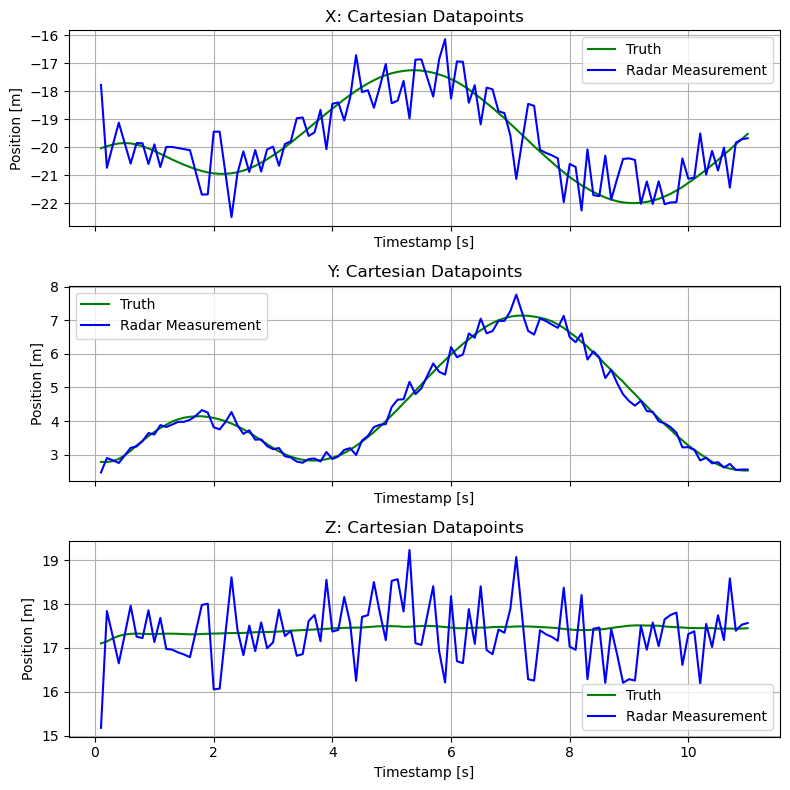

In [23]:
radar_simulator = StonesoupRadarSim(sensor_noise_level=sensor_noise, include_range_rate=incl_rr)
for traj_no, trajectory in nn_train_traj_data.items():
    traj_obj = Trajectory(store_truth_data(trajectory), traj_no)
    traj_obj.apply_sampling_gaps(remove_pct=sample_rmv)
    radar_meas = radar_simulator.simulate_radar_measurements(traj_obj)
    temp, measurement_conversion_data = radar_simulator.convert_radar_observations_to_cartesian(radar_meas)
    traj_obj.set_converted_measurement_data(measurement_conversion_data, vel=True)
    traj_obj.set_measurement_sigmas(radar_simulator.bearing_std, radar_simulator.elev_std, radar_simulator.range_std, radar_simulator.range_rate_std)
    traj_obj.visualize_truth_versus_measurement()
    # sample_df = traj_obj.return_trajectory_df()
    # sample_df_prep = traj_obj.return_nn_prepared_df(sample_df)
    
    df1 = return_sampled_df(deepcopy(traj_obj), 0)
    df2 = return_sampled_df(deepcopy(traj_obj), 25)
    df3 = return_sampled_df(deepcopy(traj_obj), 50)
    sample_df_prep = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
    
    X_mat = sample_df_prep[X_columns].values
    y_vec = sample_df_prep[y_columns].values
    break

In [24]:
# input prep
physics_metadata = {}
physics_metadata['inputPos'] = torch.tensor(sample_df_prep[["measured_x", "measured_y", "measured_z"]][:-1].to_numpy(), dtype=torch.float32)
physics_metadata['inputVel'] = torch.tensor(sample_df_prep[["measured_vx", "measured_vy", "measured_vz"]][:-1].to_numpy(), dtype=torch.float32)
physics_metadata['inputObs'] = torch.tensor(sample_df_prep[["measured_plus_x", "measured_plus_y", "measured_plus_z", "measured_plus_vx", "measured_plus_vy", "measured_plus_vz"]][:-1].to_numpy(), dtype=torch.float32)
physics_metadata['inputRngErr'] = torch.tensor(sample_df_prep[["sigma_range"]][:-1].to_numpy(), dtype=torch.float32)
physics_metadata['dtVec'] = torch.tensor(sample_df_prep[["delta_time"]][:-1].to_numpy(), dtype=torch.float32)


X_mat_in = torch.tensor(X_mat[:-1], dtype=torch.float32)
y_vec_in = torch.tensor(y_vec[1:], dtype=torch.float32)

 Epoch: 1000/1000 | Loss:   0.85 

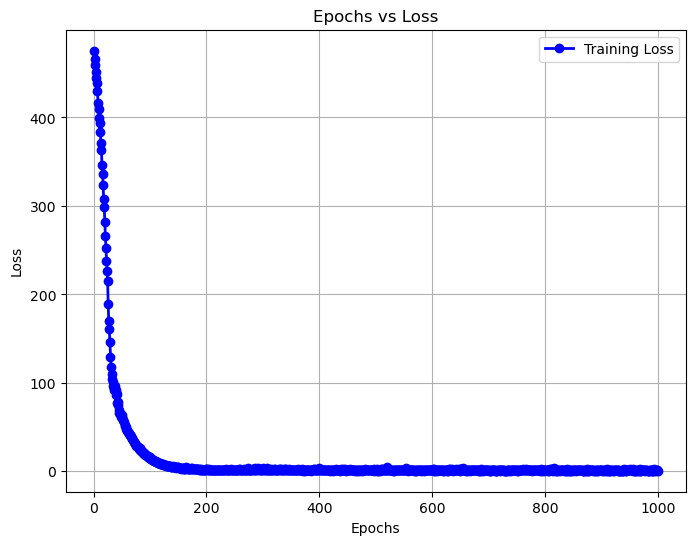

FINAL LOSS: 0.8526274561882019
CPU times: total: 40.8 s
Wall time: 5.11 s


In [25]:
%%time
pinn_model = BNKF(input_size=X_mat.shape[1], output_size=y_vec.shape[1], hidden_layer_size=64, sensor_noise_level=sensor_noise,
                 prior_sigma_lay=0.01, lambda_params=lambda_params_in, epochs=1000, bias_in=True)

pinn_model.fit(X_mat_in, y_vec_in, physics_metadata)
pinn_model.plot()
print(f"FINAL LOSS: {pinn_model.loss_values[-1]}")

In [26]:
%time 
# reclass
TestEval = Evaluator()
nn_state_est_vecs, nn_state_est_covs = pinn_model.predict(X_mat_in, physics_metadata['inputObs'], physics_metadata['inputRngErr'], apply_filter_update=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
print(nn_state_est_vecs.shape)
print(nn_state_est_covs.shape)

(248, 6)
(248, 6, 6)


In [28]:
full_pred_pos = nn_state_est_vecs[:, 0:3]
full_truth_pos = np.column_stack((traj_obj.truth_x[1:], traj_obj.truth_y[1:], traj_obj.truth_y[1:]))

In [30]:
proc_covs = []
for index, cov_vec in enumerate(nn_state_est_covs):
    proc_covs.append(nn_state_est_covs[index, 0:3, 0:3])

In [31]:
avg_err = TestEval.calculate_3d_avg_euclid_error(y_vec_in[:, 0].numpy(), y_vec_in[:, 1].numpy(), y_vec_in[:, 2].numpy(), nn_state_est_vecs[:, 0], nn_state_est_vecs[:, 1], nn_state_est_vecs[:, 2])

avg_md = TestEval.average_mahalanobis_distance(full_pred_pos, proc_covs, full_truth_pos)

avg_trace = TestEval.compute_average_covariance_trace(proc_covs)

avg_det = TestEval.compute_average_determinant(proc_covs)

print(f"MEAN ED: {avg_err}")
print(f"MEAN MD: {avg_md}")
print(f"MEAN TRACE: {avg_trace}")
print(f"MEAN DET: {avg_det}")

MEAN ED: 1.0184456252193375
MEAN MD: 29.205248267247125
MEAN TRACE: 0.546012891949021
MEAN DET: 0.005625797447647641
